In [58]:
from dipy.io.image import load_nifti_data, load_nifti, save_nifti
import nibabel as nib
from matplotlib import pyplot as plt
from dipy.align.reslice import reslice
import numpy as np
from dipy.viz import regtools
from dipy.align.imaffine import (AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)

Load data. Moving = T1(DWI); Template = StandardIMzkcjndsi

In [59]:
moving_img, moving_affine = load_nifti('sub-ADNI002S0413_ses-M132__t1_warped.nii.gz')
template_img, template_affine, voxel_size = load_nifti('HCP40_MNI_1.25mm.nii.gz', return_voxsize=True)

Reslice the brainnetome standard space to 1mm isotropic

In [60]:
new_voxel_size = (1., 1., 1.)
template_img, template_affine = reslice(template_img, template_affine, voxel_size, new_voxel_size)

Save the resliced standard

In [61]:
# save_nifti('HCP40_MNI_1mm.nii.gz', template_img, template_affine)

Start registering

In [62]:
identity = np.eye(4)
affine_map = AffineMap(identity,
                       template_img.shape, template_affine,
                       moving_img.shape, moving_affine)
resampled = affine_map.transform(moving_img)

Overlay images. No transform applied, only resampling to the same resolution.

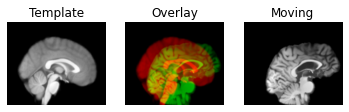

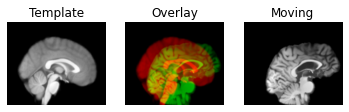

In [63]:
regtools.overlay_slices(template_img, resampled, None, 0,
                        "Template", "Moving")

In [64]:
# Mismatch Metric
nbins = 32
sampling_group = None
metric = MutualInformationMetric(nbins, sampling_group)
# The optimization strategy
level_iters = [10, 10, 5]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]

Registration object setup. Ready for registration

In [65]:
affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

In [72]:
transform_translation = TranslationTransform3D()
params0 = None
translation = affreg.optimize(template_img, moving_img, transform_translation,
                              params0, template_affine, moving_affine) # This starts computing the translation

Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [74]:
translated_img = translation.transform(moving_img)

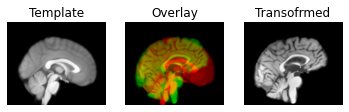

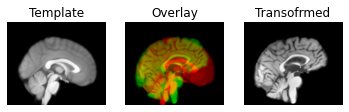

In [76]:
regtools.overlay_slices(template_img, translated_img, None, 0,
                        "Template", "Transofrmed")

This is complete bullshit yo. Optimize the registration:

In [77]:
transform_rigid = RigidTransform3D()
rigid = affreg.optimize(template_img, moving_img, transform_rigid,
                        params0, template_affine, moving_affine,
                        starting_affine=translation.affine)

Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


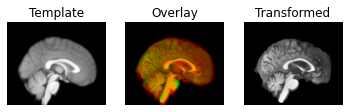

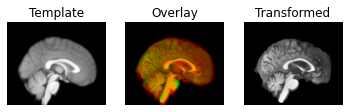

In [78]:
rigidbody_transformed = rigid.transform(moving_img)
regtools.overlay_slices(template_img, rigidbody_transformed, None, 0,
                        "Template", "Transformed")

Okay, this is WAY better. Still need some deformation tho.

In [79]:
transform_affine = AffineTransform3D()
affreg.level_iters = [1000, 1000, 100]
affine = affreg.optimize(template_img, moving_img, transform_affine,
                         params0, template_affine, moving_affine,
                         starting_affine=rigid.affine)

Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


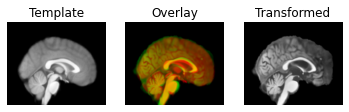

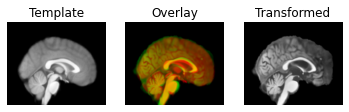

In [80]:
affine_transformed = affine.transform(moving_img)
regtools.overlay_slices(template_img, affine_transformed, None, 0,
                        "Template", "Transformed")

Okay that was kinda good finally. Translations and rotations are optimized and applied as a rigid transform; then used as a starting point for a full affine registration.
Still need some deformation though. We can use this as a starting point for a Diffeomorphic map registration for fine tuning

------------------------------------------------------------------

DIFFEOMORPHIC REGISTRATION

In [81]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.imwarp import DiffeomorphicMap
from dipy.align.metrics import CCMetric

Mismatch metric, optimization strategy and registration object:

In [82]:
metric = CCMetric(3)
level_iters = [10, 10, 5]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)

Perform registration

In [83]:
diffeom_mapping = sdr.optimize(template_img, moving_img,
                       template_affine, moving_affine,
                       affine.affine)

In [84]:
diffeom_transformed = diffeom_mapping.transform(moving_img)

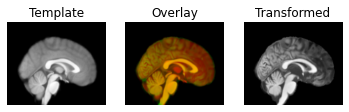

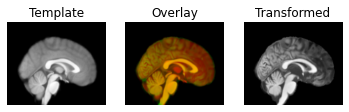

In [87]:
regtools.overlay_slices(template_img, diffeom_transformed, None, 0,
                        "Template", "Transformed")

It is clear that we need this, it is reeaaaaaally good.
Let's try to get the INVERSE mapping.

Apply the INVERSE DIFFEOMORPHIC MAPPING to the STANDARD image to see if it matches the moving image.

In [88]:
STD_inv_diffeom_transformed = diffeom_mapping.transform_inverse(template_img, 'linear')

In [89]:
type(STD_inv_diffeom_transformed)

numpy.ndarray

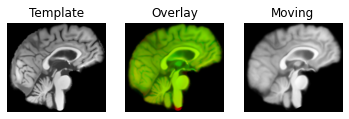

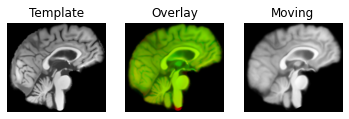

In [90]:
regtools.overlay_slices(moving_img, STD_inv_diffeom_transformed, None, 0, "Template", "Moving") # In this case the moving image is "warped_inv"

Now that our registration is good, we need to apply this procedure to the atlas.
For this:

    1.- Apply the inverse diffeomorphic transformation to the ATLAS.

    2.- Apply the INVERSE affine transformation to the ATLAS (including the rotation+translation that involves rigid body transformation)

Load the atlas

In [91]:
atlas_img, atlas_affine = load_nifti('BN_Atlas_246_1mm.nii.gz')

In [92]:
inv_atlas = diffeom_mapping.transform_inverse(atlas_img, 'linear')

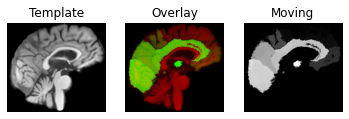

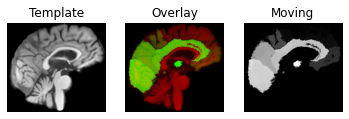

In [93]:
regtools.overlay_slices(moving_img, inv_atlas, None, 0, "Template", "Moving")

So now we see that the ATLAS is moved to the DWI space. The diffeomorphic map encapsulates the previously done transformations as it was optimized with them being a starting point.

In [99]:
B0_im, B0_affine = load_nifti('b0_resampled.nii.gz')

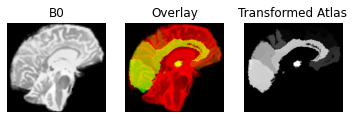

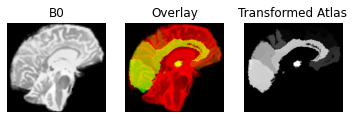

In [100]:
regtools.overlay_slices(B0_im, inv_atlas, None, 0, "B0", "Transformed Atlas")

In [102]:
inv_atlas_affine = B0_affine
# save_nifti('inverted_atlas.nii.gz', inv_atlas, inv_atlas_affine)